# Getting Started with Qwen2.5-0.5B

This notebook provides a tutorial on working with the Qwen2.5-0.5B model from Hugging Face's Transformers library. Qwen2.5 is the latest series of large language models developed by the Qwen team.

## What we'll cover:
- Introduction to Qwen2.5 models
- Loading the model and tokenizer
- Exploring model architecture
- Basic text generation
- Examining model layers and parameters

## Qwen2.5 Model Overview

Qwen2.5 is the latest series of large language models from the Qwen team. Key features include:

- Range of model sizes from 0.5B to 72B parameters (we're using the 0.5B version)
- Based on a transformer architecture with RoPE (Rotary Position Embedding), SwiGLU activation, RMSNorm, and Attention QKV bias
- Grouped Query Attention (GQA) with 14 query heads and 2 key/value heads
- Support for up to 32,768 tokens context length (base model)
- Improved capabilities in coding, mathematics, and structured data handling
- Support for 29+ languages including Chinese, English, French, Spanish, and more

For more information, refer to the [Qwen GitHub repository](https://github.com/QwenLM/Qwen) and [Hugging Face model page](https://huggingface.co/Qwen/Qwen2.5-0.5B).

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # in case of any OpenMP Library conflict

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

plt.style.use('ggplot')
sns.set(style="whitegrid")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Loading the Model and Tokenizer

Let's start by loading the Qwen2.5-0.5B model and its associated tokenizer. The model will be loaded with `AutoModelForCausalLM` and the tokenizer with `AutoTokenizer`.

### Note:
- We'll use `device_map="auto"` to automatically place the model on the appropriate device (GPU/CPU)]
- Qwen2.5 models require transformers>=4.37.0

In [2]:
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Setting device_map to "auto" will use GPU if available
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32, 
    device_map="auto"
)

print(f"Model loaded: {model_name}")
print(f"Model type: {type(model).__name__}")
print(f"Tokenizer type: {type(tokenizer).__name__}")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model loaded: Qwen/Qwen2.5-0.5B
Model type: Qwen2ForCausalLM
Tokenizer type: Qwen2TokenizerFast


## Exploring the Model Architecture

Let's examine the architecture of the Qwen2.5-0.5B model. We'll look at:
1. The overall model structure
2. Configuration parameters 
3. Key components (embeddings, attention layers, etc.)

Qwen2.5-0.5B has several notable architectural features:
- 24 transformer layers
- Grouped Query Attention (GQA) with 14 query heads and 2 key/value heads
- Total parameters: 0.49B (490M), with 0.36B (360M) non-embedding parameters

In [3]:
model_config = model.config

print(f"Model size: {sum(p.numel() for p in model.parameters())/1e6:.2f} million parameters")
print(f"Vocabulary size: {model_config.vocab_size}")
print(f"Hidden size: {model_config.hidden_size}")
print(f"Number of layers: {model_config.num_hidden_layers}")
print(f"Number of attention heads: {model_config.num_attention_heads}")
print(f"Number of KV heads: {model_config.num_key_value_heads}")
print(f"Maximum sequence length: {model_config.max_position_embeddings}")

print("\nFull model configuration:")
print(model_config)

Model size: 494.03 million parameters
Vocabulary size: 151936
Hidden size: 896
Number of layers: 24
Number of attention heads: 14
Number of KV heads: 2
Maximum sequence length: 32768

Full model configuration:
Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "use_mrope": false,
  "use_sliding_window": false,
  "vocab_size": 151

In [4]:
def visualize_model_hierarchy(model, depth=0, max_depth=2):
    result = []
    prefix = "  " * depth
    
    for name, child in model.named_children():
        param_count = sum(p.numel() for p in child.parameters())
        result.append(f"{prefix}├─ {name}: {type(child).__name__} ({param_count/1e6:.2f}M params)")
        
        if depth < max_depth:
            child_result = visualize_model_hierarchy(child, depth + 1, max_depth)
            result.extend(child_result)
    
    return result
    
hierarchy = visualize_model_hierarchy(model)

print("Model Hierarchy (major components):")
for line in hierarchy:
    print(line)

Model Hierarchy (major components):
├─ model: Qwen2Model (494.03M params)
  ├─ embed_tokens: Embedding (136.13M params)
  ├─ layers: ModuleList (357.90M params)
    ├─ 0: Qwen2DecoderLayer (14.91M params)
    ├─ 1: Qwen2DecoderLayer (14.91M params)
    ├─ 2: Qwen2DecoderLayer (14.91M params)
    ├─ 3: Qwen2DecoderLayer (14.91M params)
    ├─ 4: Qwen2DecoderLayer (14.91M params)
    ├─ 5: Qwen2DecoderLayer (14.91M params)
    ├─ 6: Qwen2DecoderLayer (14.91M params)
    ├─ 7: Qwen2DecoderLayer (14.91M params)
    ├─ 8: Qwen2DecoderLayer (14.91M params)
    ├─ 9: Qwen2DecoderLayer (14.91M params)
    ├─ 10: Qwen2DecoderLayer (14.91M params)
    ├─ 11: Qwen2DecoderLayer (14.91M params)
    ├─ 12: Qwen2DecoderLayer (14.91M params)
    ├─ 13: Qwen2DecoderLayer (14.91M params)
    ├─ 14: Qwen2DecoderLayer (14.91M params)
    ├─ 15: Qwen2DecoderLayer (14.91M params)
    ├─ 16: Qwen2DecoderLayer (14.91M params)
    ├─ 17: Qwen2DecoderLayer (14.91M params)
    ├─ 18: Qwen2DecoderLayer (14.91M pa

## Examining Specific Model Layers

Let's take a closer look at some of the key components of the Qwen2.5-0.5B model:
1. Token embeddings
2. Grouped Query Attention (GQA) mechanism
3. Feed-forward networks with SwiGLU activation

The model follows the standard transformer decoder architecture with several enhancements:
- Word (token) embeddings
- Rotary Position Embeddings (RoPE) for positional encoding
- Grouped Query Attention (14 query heads, 2 key/value heads)
- Feed-forward networks with SwiGLU activation
- RMSNorm for layer normalization

In [5]:
# 1. Embeddings
embed_layer = model.model.embed_tokens
print(f"Embedding layer shape: {embed_layer.weight.shape}")
print(f"Embedding dimension: {embed_layer.weight.shape[1]}")

# 2. First and last decoder layers
first_layer = model.model.layers[0]
last_layer = model.model.layers[-1]

print("\nAttention in first layer:")
# Let's check the attributes available in the attention mechanism
attention_attributes = dir(first_layer.self_attn)
print(f"Attention configuration from model config:")
print(f"Number of Q heads: {model_config.num_attention_heads}")
print(f"Number of KV heads: {model_config.num_key_value_heads}")
print(f"Head dimension: {model_config.hidden_size // model_config.num_attention_heads}")
print(f"Grouped Query Attention ratio: {model_config.num_attention_heads / model_config.num_key_value_heads}")

# 3. Output projection
output_layer = model.lm_head
print(f"\nOutput layer shape: {output_layer.weight.shape}")

# 4. Feed-forward network in first layer
print("\nFeed-forward network in first layer:")
print(f"Input dimension: {first_layer.mlp.gate_proj.weight.shape[1]}")
print(f"Hidden dimension: {first_layer.mlp.gate_proj.weight.shape[0]}")
print(f"Output dimension: {first_layer.mlp.down_proj.weight.shape[0]}")

Embedding layer shape: torch.Size([151936, 896])
Embedding dimension: 896

Attention in first layer:
Attention configuration from model config:
Number of Q heads: 14
Number of KV heads: 2
Head dimension: 64
Grouped Query Attention ratio: 7.0

Output layer shape: torch.Size([151936, 896])

Feed-forward network in first layer:
Input dimension: 896
Hidden dimension: 4864
Output dimension: 896


## Basic Text Generation

Now let's try using the model for text generation. We'll provide a prompt and have the model generate a continuation.

Note that the Qwen2.5-0.5B base model is not instruction-tuned, so it's better for completion tasks rather than instruction following.

In [6]:
def generate_text(prompt, max_new_tokens=150):
    """Generate text from a prompt."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1
        )
    
    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Format for display
    highlighted_text = generated_text.replace(prompt, f"<b>{prompt}</b>")
    return highlighted_text

print("Note: This is the base model which is designed for text completion, not instruction-following.")
print("For better responses to prompts, use the instruction-tuned version: Qwen/Qwen2.5-0.5B-Chat\n")

prompts = [
    "The future of artificial intelligence is",
    "A simple recipe for chocolate cake includes",
    "The best way to learn programming is"
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    generated = generate_text(prompt)
    display(HTML(f"<div style='background:#f5f5f5; padding:10px; border-radius:5px;'>{generated}</div>"))
    print("-" * 80)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Note: This is the base model which is designed for text completion, not instruction-following.
For better responses to prompts, use the instruction-tuned version: Qwen/Qwen2.5-0.5B-Chat


Prompt: The future of artificial intelligence is


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


--------------------------------------------------------------------------------

Prompt: A simple recipe for chocolate cake includes


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


--------------------------------------------------------------------------------

Prompt: The best way to learn programming is


--------------------------------------------------------------------------------


## Exploring Grouped Query Attention (GQA)

Qwen2.5-0.5B uses Grouped Query Attention (GQA), which significantly reduces computational costs while maintaining model quality.

In Grouped Query Attention:
- Multiple query heads share a single key-value head
- Qwen2.5-0.5B has 14 query heads but only 2 key-value heads
- This means each key-value head is shared across 7 query heads (14/2 = 7)
- This reduces memory usage during inference by ~30% with minimal quality impact

Let's look at how this architecture is implemented in the model.

Query projection shape: torch.Size([896, 896])
Key projection shape: torch.Size([128, 896])
Value projection shape: torch.Size([128, 896])

Ratio of Q projection size to K projection size: 7.0
This confirms the 14:2 ratio of query heads to key-value heads

Approximate memory savings for KV cache: 85.7%
This is a significant improvement, especially for long context generation!


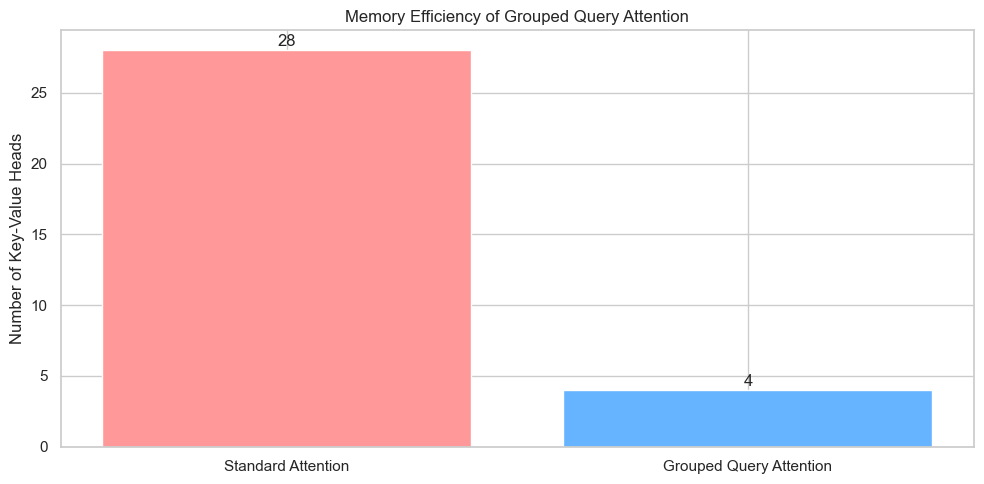

In [7]:
first_layer = model.model.layers[0]

# Look at the query, key, and value projection matrices
q_proj = first_layer.self_attn.q_proj
k_proj = first_layer.self_attn.k_proj
v_proj = first_layer.self_attn.v_proj

print(f"Query projection shape: {q_proj.weight.shape}")
print(f"Key projection shape: {k_proj.weight.shape}")
print(f"Value projection shape: {v_proj.weight.shape}")

# Calculate the ratio
q_size = q_proj.weight.shape[0]
k_size = k_proj.weight.shape[0]
ratio = q_size / k_size

print(f"\nRatio of Q projection size to K projection size: {ratio:.1f}")
print(f"This confirms the {model_config.num_attention_heads}:{model_config.num_key_value_heads} ratio of query heads to key-value heads")

# Visualize the memory savings
kv_heads_if_standard = model_config.num_attention_heads * 2  # K and V for each head
kv_heads_with_gqa = model_config.num_key_value_heads * 2     # K and V for each KV head

memory_savings_percent = (1 - kv_heads_with_gqa / kv_heads_if_standard) * 100

print(f"\nApproximate memory savings for KV cache: {memory_savings_percent:.1f}%")
print("This is a significant improvement, especially for long context generation!")

# Create a bar chart to visualize the difference
labels = ['Standard Attention', 'Grouped Query Attention']
kv_counts = [kv_heads_if_standard, kv_heads_with_gqa]

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, kv_counts, color=['#ff9999', '#66b3ff'])
plt.ylabel('Number of Key-Value Heads')
plt.title('Memory Efficiency of Grouped Query Attention')

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Introduction to Steering Vectors with Qwen2.5

Steering vectors are a technique to guide language model generation by manipulating the activation patterns in the model. They can be used to control the style, tone, or content domain of the generated text.

Basic steps for creating and using a steering vector:
1. Generate embeddings for examples in your target category (e.g., "technical writing")
2. Generate embeddings for examples in a contrasting category (e.g., "creative writing") 
3. Calculate the difference vector, which represents the "direction" from one category to another
4. During generation, add this vector (scaled by a strength parameter) to manipulate the output

Let's implement a basic version of this technique with Qwen2.5-0.5B.

Formal-Informal steering vector shape: torch.Size([896])
Technical-Creative steering vector shape: torch.Size([896])

Cosine similarity between vectors: 0.4514
A value close to 1 would mean the vectors are very similar,
close to 0 means they're orthogonal (unrelated),
and close to -1 means they're opposite.


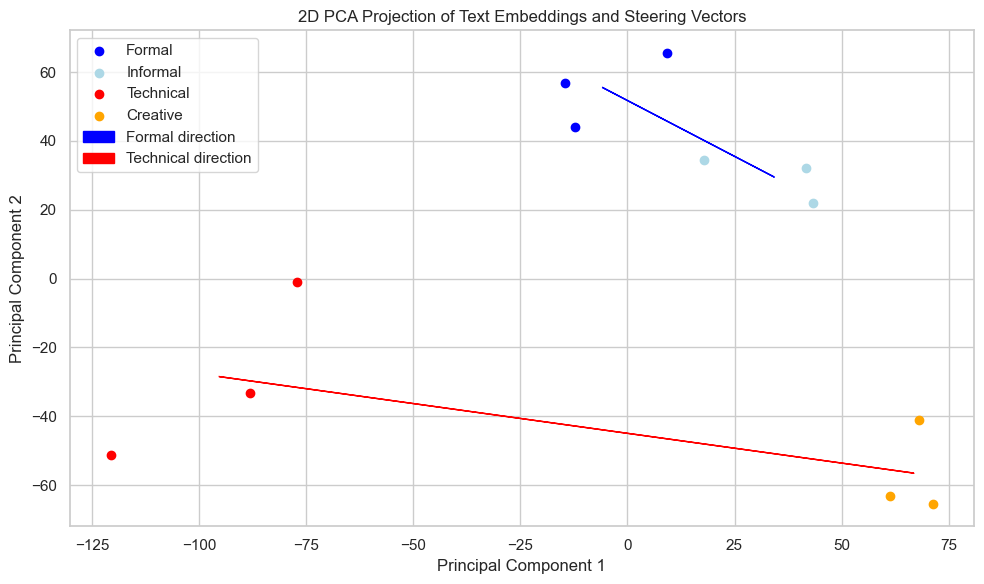


Note: In a real application, you would integrate steering vectors into the generation process
by modifying the hidden states during inference. This requires custom modifications to the model's
forward pass, which is beyond the scope of this notebook.


In [8]:
def get_model_embedding(text):
    """Get the embeddings for a given text from the model."""
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model(
            **inputs,
            output_hidden_states=True,
            return_dict=True
        )
    
    # Get the last hidden state (representation)
    last_hidden_state = outputs.hidden_states[-1][0].mean(dim=0)
    return last_hidden_state

def create_steering_vector(positive_texts, negative_texts=None):
    """Create a steering vector from positive and negative examples."""
    # Get embeddings for positive examples
    positive_embeddings = [get_model_embedding(text) for text in positive_texts]
    positive_center = torch.stack(positive_embeddings).mean(dim=0)
    
    # If negative examples are provided, use them to refine the vector
    if negative_texts:
        negative_embeddings = [get_model_embedding(text) for text in negative_texts]
        negative_center = torch.stack(negative_embeddings).mean(dim=0)
        
        # The steering vector is the difference between positive and negative centers
        steering_vector = positive_center - negative_center
    else:
        steering_vector = positive_center
    
    # Normalize the vector
    steering_vector = steering_vector / torch.norm(steering_vector)
    return steering_vector

# Create example steering vectors for different styles
formal_texts = [
    "I would like to inquire about your availability for a meeting next week.",
    "The committee has reviewed the proposal and will provide feedback by Friday.",
    "We respectfully request your attendance at the annual board meeting."
]

informal_texts = [
    "Hey, are you free to chat next week?",
    "We looked at your idea and we'll let you know what we think by Friday!",
    "Hope you can make it to our yearly get-together!"
]

technical_texts = [
    "The algorithm complexity is O(n log n) in the average case.",
    "Python's dictionary implementation uses hash tables for efficient lookup.",
    "The system architecture consists of three primary microservices."
]

creative_texts = [
    "The sunset painted the sky with hues of orange and purple.",
    "Her laughter echoed through the ancient halls like wind chimes.",
    "The old oak tree whispered secrets to anyone willing to listen."
]

# Create the steering vectors
formal_informal_vector = create_steering_vector(formal_texts, informal_texts)
technical_creative_vector = create_steering_vector(technical_texts, creative_texts)

print(f"Formal-Informal steering vector shape: {formal_informal_vector.shape}")
print(f"Technical-Creative steering vector shape: {technical_creative_vector.shape}")

# Measure cosine similarity between the two vectors
cosine_similarity = torch.nn.functional.cosine_similarity(
    formal_informal_vector.unsqueeze(0), 
    technical_creative_vector.unsqueeze(0)
).item()

print(f"\nCosine similarity between vectors: {cosine_similarity:.4f}")
print("A value close to 1 would mean the vectors are very similar,")
print("close to 0 means they're orthogonal (unrelated),")
print("and close to -1 means they're opposite.")

from sklearn.decomposition import PCA

# Combine all text examples
all_texts = formal_texts + informal_texts + technical_texts + creative_texts
all_embeddings = [get_model_embedding(text).cpu().numpy() for text in all_texts]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:3, 0], embeddings_2d[:3, 1], color='blue', label='Formal')
plt.scatter(embeddings_2d[3:6, 0], embeddings_2d[3:6, 1], color='lightblue', label='Informal')
plt.scatter(embeddings_2d[6:9, 0], embeddings_2d[6:9, 1], color='red', label='Technical')
plt.scatter(embeddings_2d[9:12, 0], embeddings_2d[9:12, 1], color='orange', label='Creative')

formal_center = np.mean(embeddings_2d[:3], axis=0)
informal_center = np.mean(embeddings_2d[3:6], axis=0)
technical_center = np.mean(embeddings_2d[6:9], axis=0)
creative_center = np.mean(embeddings_2d[9:12], axis=0)

plt.arrow(informal_center[0], informal_center[1], 
          formal_center[0]-informal_center[0], formal_center[1]-informal_center[1], 
          head_width=0.02, head_length=0.03, fc='blue', ec='blue', label='Formal direction')

plt.arrow(creative_center[0], creative_center[1], 
          technical_center[0]-creative_center[0], technical_center[1]-creative_center[1], 
          head_width=0.02, head_length=0.03, fc='red', ec='red', label='Technical direction')

plt.title('2D PCA Projection of Text Embeddings and Steering Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nNote: In a real application, you would integrate steering vectors into the generation process")
print("by modifying the hidden states during inference. This requires custom modifications to the model's")
print("forward pass, which is beyond the scope of this notebook.")